# Plot logits reweighting results for topical decoding
In this notebook the results for the topical decoding via logits reweighting are analysed

## Overview
1. Imports
    - 1.1. Import libraries
    - 1.2. Import model and tokenizer
    - 1.3. Import NEWTS dataset
    - 1.4. Import LDA model

2. Analyze the summaries

# 1. Imports

## 1.1 Import libraries

In [27]:
import sys
sys.path.append('../..')
import os, json
import matplotlib.pyplot as plt
import numpy as np
from utils.topical_evaluations import topic_scores
from rouge_score import rouge_scorer

## 1.2 Import results 

In [28]:
# Define the path to the data directory (relative to the current notebook's location)
data_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data/results_logits_reweighting')

# Define the full path to the summaries JSON file
summaries_file_path = os.path.join(data_dir, 'logits_reweighting_Flan_T5_10_80_150.json')

# Read the JSON object from the file
with open(summaries_file_path, 'r') as f:
    summaries = json.load(f)

In [29]:
summaries[0]

{'tid': 218,
 'article': "An American tourist has spent the night stranded in the Blue Mountains, west of Sydney, after she fell 15 metres off a cliff while bushwalking. The 25-year-old from the US state of Wisconsin was walking near Pulpit Rock, Mount Victoria with a group of friends on Friday when she slipped from a track. She fell about 15 metres and rolled a further 20 metres down a steep slope, police say. Rescue teams escort a 25-year-old US tourist after she spent the night stranded in the Blue Mountains after falling 15 metres off a cliff . Rescue crews found the woman suffering a possible broken ankle and broken ribs. She remained with an ambulance team overnight due to low light and foggy weather conditions. Blue Mountains Police Rescue Sergeant Dallas Atkinson told ABC a helicopter was deployed to finish the rescue this morning. 'After she fell yesterday she was accessed a short time later by police and ambulance,' Sergeant Atkinson said. 'It was determined that she had sust

In [30]:
# the reweighting factors are the keys of the dictionary
REWEIGHTING_FACTORS = summaries[0]['reweighting_factors']
print(REWEIGHTING_FACTORS)
NUM_ARTICLES = len(summaries)
print(NUM_ARTICLES)
MODEL_NAME = 'Flan_T5_base'

[0.01, 0.1, 1, 10, 100]
10


## 1.3 Import the NEWTS dataset

In [5]:
from utils.newts_lda_utils import read_NEWTS_test, read_NEWTS_train

# Load the NEWTS training set
newts_train = read_NEWTS_train()
newts_test = read_NEWTS_test()

2024-03-28 11:43:09,328 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-28 11:43:09,391 - INFO - Successfully loaded NEWTS training set.
2024-03-28 11:43:09,392 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-28 11:43:09,409 - INFO - Successfully loaded NEWTS testing set.


## 1.4. Import LDA model

In [6]:
from utils.newts_lda_utils import read_LDA

# Load the LDA model and dictionary
lda, dictionary = read_LDA()
# Warning "WARNING:root:random_state not set so using default value" is inconsequential for inference

2024-03-28 11:43:10,940 - INFO - Data directory found at /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data.
2024-03-28 11:43:10,940 - INFO - loading LdaModel object from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model
2024-03-28 11:43:11,050 - INFO - loading id2word recursively from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model.id2word.* with mmap=r
2024-03-28 11:43:11,051 - INFO - loading expElogbeta from /Users/joschka/Documents/0_Studium/0_ML_Master/0_current_lectures/NLP_practical_project/local_topical_decoding/data/LDA_250/lda.model.expElogbeta.npy with mmap=r
2024-03-28 11:43:11,056 - INFO - setting ignored attribute state to None
2024-03-28 11:43:11,057 - INFO - setting ignored attribute dispatcher to None
2024-03-28 11:43:11,057 - INFO - LdaM

# 2. Analyse the results

## Calculate the Topic Scores

In [7]:
def calculate_topic_scores_for_summaries(articles_summaries, lda, method="lemmatize", dictionary=None):
    """
    Calculate topic scores for summaries generated with different reweighting factors.
    
    :param articles_summaries: List of dictionaries, each containing summaries for an article under different reweighting factors.
    :param lda: The trained LDA model.
    :param method: The method used for topic scoring, default is 'lemmatize'.
    :param dictionary: The dictionary used in the LDA model, if needed for the method.
    :return: A dictionary where keys are reweighting factors and values are average topic scores.
    """
    topic_scores_per_factor = {factor: [] for factor in REWEIGHTING_FACTORS}
    
    for article_summary in articles_summaries:
        tid1 = article_summary["tid"]  # Assuming each article has a single topic ID associated with it
        
        for factor in REWEIGHTING_FACTORS:
            summary_text = article_summary[str(factor)]
            score = topic_scores(documents=[summary_text], lda=lda, tids=[tid1], method=method, dictionary=dictionary)[0]
            topic_scores_per_factor[str(factor)].append(score)
    
    # Calculate average scores across all articles for each factor
    avg_topic_scores_per_factor = {factor: np.mean(scores) for factor, scores in topic_scores_per_factor.items()}
    
    return avg_topic_scores_per_factor

In [8]:
# Calculate average topic scores for summaries
avg_topic_scores = calculate_topic_scores_for_summaries(summaries, lda, method="lemmatize", dictionary=dictionary)

In [21]:
def plot_topic_scores(avg_topic_scores, num_articles):
    """
    Plot the average topic scores for different reweighting factors.

    :param avg_topic_scores: Dictionary of average topic scores with reweighting factors as keys.
    """
    # Prepare data for the plot
    labels = [f'Factor {factor}' for factor in avg_topic_scores.keys()]  # Labels for each reweighting factor
    scores = list(avg_topic_scores.values())  # Average scores
    colors = plt.cm.viridis(np.linspace(0, 1, len(avg_topic_scores)))  # Generate distinct colors for each factor

    # Create the plot
    plt.figure(figsize=(8, 5))

    # Creating the bar plot
    plt.bar(labels, scores, color=colors, edgecolor='grey')

    # Adding labels, title, and annotations
    plt.xlabel('Reweighting Factor', fontweight='bold')
    plt.ylabel('Average Topic Score', fontweight='bold')
    plt.title(f'Comparison of Average Topic Scores across Reweighting Factors\nSample Size per Bar: {num_articles}', fontweight='bold')

    # Optionally, add text annotations with the exact score on each bar
    for i, score in enumerate(scores):
        plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('../../plots/logits_reweighting_{0}_{1}_topical_scores.png'.format(MODEL_NAME, num_articles))
    plt.show()

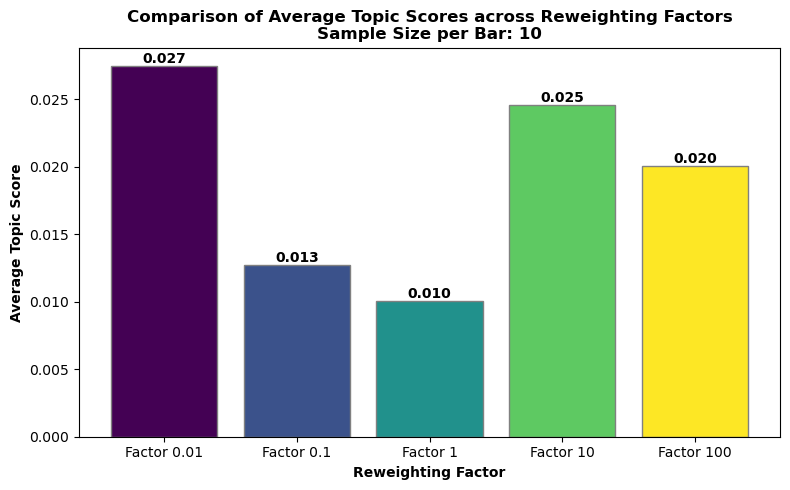

In [24]:
# Plot the topic scores
plot_topic_scores(avg_topic_scores, NUM_ARTICLES)

In [11]:
def compute_rouge_scores(generated_summary, reference_summary):
    """
    Compute ROUGE-1, ROUGE-2, and ROUGE-L scores between a generated summary and a reference summary.
    
    :param generated_summary: The generated summary text.
    :param reference_summary: The reference summary text.
    :return: A dictionary with keys 'rouge1', 'rouge2', and 'rougeL' and values as the corresponding scores.
    """
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_summary, generated_summary)
    
    # Extract F1 scores for simplicity
    return {key: score.fmeasure for key, score in scores.items()}

In [12]:
def calculate_rouge_for_factors(summaries):
    """
    Calculate ROUGE scores for summaries generated with different reweighting factors against reference summaries.
    
    :param summaries: List of dictionaries, each containing summaries for an article under different reweighting factors and a reference summary.
    :return: A dictionary of dictionaries containing ROUGE scores, keyed first by reweighting factor, then by article index.
    """
    rouge_scores = {factor: [] for factor in REWEIGHTING_FACTORS}  # Initialize storage for ROUGE scores

    for article in summaries:
        reference_summary = article["summary"]  # The reference summary for comparison
        
        for factor in REWEIGHTING_FACTORS:
            generated_summary = article[factor]  # The generated summary for the current reweighting factor
            scores = compute_rouge_scores(generated_summary, reference_summary)  # Compute ROUGE scores
            
            # Append the scores for this article to the list of scores for the current factor
            rouge_scores[factor].append(scores)

    return rouge_scores

In [13]:
rouge_scores = calculate_rouge_for_factors(summaries)

2024-03-28 11:43:32,444 - INFO - Using default tokenizer.
2024-03-28 11:43:32,447 - INFO - Using default tokenizer.
2024-03-28 11:43:32,448 - INFO - Using default tokenizer.
2024-03-28 11:43:32,450 - INFO - Using default tokenizer.
2024-03-28 11:43:32,451 - INFO - Using default tokenizer.
2024-03-28 11:43:32,452 - INFO - Using default tokenizer.
2024-03-28 11:43:32,454 - INFO - Using default tokenizer.
2024-03-28 11:43:32,457 - INFO - Using default tokenizer.
2024-03-28 11:43:32,459 - INFO - Using default tokenizer.
2024-03-28 11:43:32,460 - INFO - Using default tokenizer.
2024-03-28 11:43:32,462 - INFO - Using default tokenizer.
2024-03-28 11:43:32,463 - INFO - Using default tokenizer.
2024-03-28 11:43:32,464 - INFO - Using default tokenizer.
2024-03-28 11:43:32,466 - INFO - Using default tokenizer.
2024-03-28 11:43:32,467 - INFO - Using default tokenizer.
2024-03-28 11:43:32,468 - INFO - Using default tokenizer.
2024-03-28 11:43:32,470 - INFO - Using default tokenizer.
2024-03-28 11:

In [25]:
def plot_rouge_scores(rouge_scores, num_articles):
    """
    Plot the average ROUGE scores for different reweighting factors.

    :param rouge_scores: Dictionary of dictionaries containing ROUGE scores, keyed by reweighting factor.
    :param num_articles: Total number of articles summarized.
    """
    # Calculate average scores for each factor across all articles
    avg_scores = {}
    for factor, articles_scores in rouge_scores.items():
        # Initialize sums of scores
        total_rouge1, total_rouge2, total_rougeL = 0, 0, 0
        for scores in articles_scores:
            total_rouge1 += scores['rouge1']
            total_rouge2 += scores['rouge2']
            total_rougeL += scores['rougeL']
        # Calculate and store average scores
        avg_scores[factor] = {
            'rouge1': total_rouge1 / len(articles_scores),
            'rouge2': total_rouge2 / len(articles_scores),
            'rougeL': total_rougeL / len(articles_scores)
        }

    # Assuming equal importance, compute a simple average of the ROUGE metrics for visualization
    simple_avg_scores = {factor: np.mean(list(metric_scores.values())) for factor, metric_scores in avg_scores.items()}

    # Prepare data for plotting
    labels = [f'Factor {factor}' for factor in simple_avg_scores.keys()]
    scores = list(simple_avg_scores.values())
    colors = plt.cm.viridis(np.linspace(0, 1, len(simple_avg_scores)))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.bar(labels, scores, color=colors, edgecolor='grey')

    plt.xlabel('Reweighting Factor', fontweight='bold')
    plt.ylabel('Average ROUGE Score', fontweight='bold')
    plt.title(f'Comparison of Average ROUGE Scores across Reweighting Factors\nSample Size per Bar: {num_articles}', fontweight='bold')

    # Annotate bars with the exact score
    for i, score in enumerate(scores):
        plt.text(i, score, f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('../../plots/logits_reweighting_{0}_{1}_rouge_scores.png'.format(MODEL_NAME, num_articles))
    plt.show()

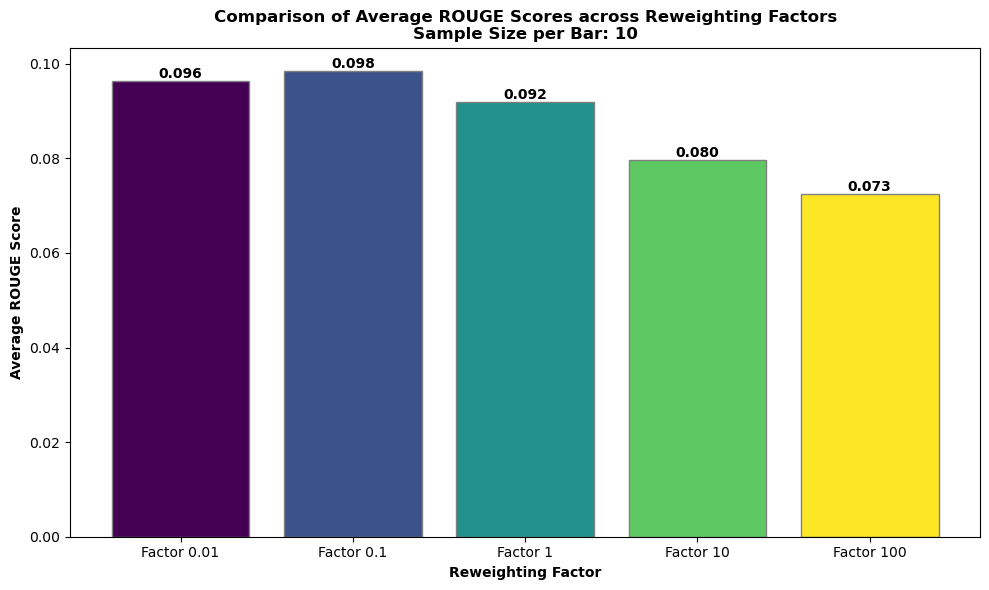

In [26]:
plot_rouge_scores(rouge_scores, NUM_ARTICLES)